## Investigation of the VAB outcome: the virtual aging analysis

The current notebook explores the virtual aging simulation results for the 50 youngest subjects of the 1000BRAINS dataset [(Caspers et al., 2014)](https://www.frontiersin.org/articles/10.3389/fnagi.2014.00149/full) based on the masking approach shown in `$MYPATH/aging_virtual_brain/notebooks/vab_github_simulation_virtual_aging.ipynb` and `$MYPATH/aging_virtual_brain/notebooks/vab_github_sc_investigation.ipynb`. As a short recap, we report the formula of the artificial aging via intehemispheric decrease:

The formula for virtually aging is:
    $$SC_{aged} = SC_{0} - \alpha * SC_{0} * M_{inter},$$

where $M_{inter}$

$$ M_{inter} = \begin{bmatrix}
\mathbf{0} & \mathbf{1} \\
\mathbf{1} & \mathbf{0} 
\end{bmatrix}$$

We are going to provide details on the following topics:

1. The brain fluidity landscape for the $(G-\alpha)$ dimensions for a couple of example subjects
2. The trend of $G$ network modulation for the 50 subjects
3. Summary statistics trends in function of interhemispheric SC deterioration ($\alpha$).

### Data alert 

The current notebook assumes that the dataset is located in the folder `$MYPATH/aging_virtual_brain/data/external` and the simulated dataset is located in the folder `$MYPATH/aging_virtual_brain/data/interim`. First, verify that the dataset is present before running any codeblock.

The access to this dataset is regulated by the EBRAINS platform. Therefore, any user must register to EBRAINS and request the access to dataset on the same platform by accepting the Data Users Agreement, which is a valid MTA.

Once registered, the access to this dataset is protected by the Human Data Gateway, and has to be explicitly requested. Please click the following link: [request access](https://data-proxy.ebrains.eu/datasets/83407c06-b494-4307-861e-d06a5aecdf8a). When granted, the right to access lasts 24 hours.

Alternatively, the access request link can be found in the Knowledge Graph page of the dataset under the *Get data* menu item: https://doi.org/10.25493/6640-3XH.

<div>
<img src="image_1000BD_EBRAINS.png" width="1000"/>
</div>

Have you download the data according to the suggested procedure? If yes, go ahead. If no, 
### ***Re-read carefully the data alert block***

In [1]:
import numpy as np
import matplotlib.pyplot as plt
#import utils
from matplotlib import rcParams
rcParams['figure.figsize'] = 15,6
from src import data, analysis, simulation, FC_analysis, viz, Burstiness 
from tvb.datatypes.time_series import *
import socket
from datetime import datetime
from multiprocessing import Pool
from functools import partial
import os
from scipy.io.matlab import loadmat
from tvb.simulator.lab import *
#import ipywidgets as widgets
# Pay attention that it crashes with any other interactive package
#from tvb.simulator.plot.phase_plane_interactive import PhasePlaneInteractive
LOG = get_logger('demo')
import scipy.stats
#import sklearn
#from sklearn.decomposition import FastICA
import time
import resource
from sys import getsizeof
import pandas as pd
import os
from scipy import stats
import numpy.matlib 
from mpl_toolkits.axes_grid1 import make_axes_locatable
import re
import warnings
warnings.filterwarnings("ignore")

/Users/mariolavanga/Documents/GitHub/ageing_virtual_brain/env/lib/python3.7/site-packages/tvb/datatypes/surfaces.py:61: UserWarning: Geodesic distance module is unavailable; some functionality for surfaces will be unavailable.
  warnings.warn(msg)


In [2]:
# Upload Julich dataset, the list of regions and the list of metadata of each patient. Please pay attention that the code uploads both 
# subjs list of the folder and the subj list of csv. Do refer to the variable subjs and the sorted output based on the available data in the folder
separator = ''
jul    = data.Julich() 
# subjs  = jul.list_subjects()
parce_list = jul.parcellation_100()
#subj_age,gender,education,subj_ID = jul.metadata()
subj_age,gender,education,subj_ID,age_sort,gender_sort,gender_sort,subjs = jul.metadata()

In [3]:
G_VECT     = np.arange(1.5,3.25,0.05)
G_TAU      = list(G_VECT.round(7))
N_VECT     = np.array([0.03,0.035,0.04,0.045])
N_TAU      = list(N_VECT.round(7))
A_TAU      = np.arange(0.0,1.0,0.05)
B_TAU      = np.array([0.0])
A_TAU      = list(A_TAU.round(2))
B_TAU      = list(B_TAU.round(2))
ALPHA1     = A_TAU[0]
ALPHA2     = B_TAU[0]

## Optimized FCD features and tuning parameters

Similary to the empirical connectome-based analysis, the fludity landscape or the parameter map is a 315 entries grid of $\sigma^2(FCD)$, where the two dimensions are represented by two parameter range: $G = [1.5 - 3.2]$ and $\sigma^2 = [0.01-0.05]$. We can collect the entries with two nested for loops. At the same time, we can also collect the two main target functional features of our analysis, which are the average Homotopic FC, $<Homotopic_{FC}>$, and the FCD variance difference, $\sigma^2_{diff}$ (see details in the second part). Once all the maps are collect in array of matrices or a tensor, we can detect the maximum for each matrix and determine the pair of tuning parameters ($G$,$\sigma^2$) to simulate data for each subject and the associated BOLD data, $FCD$ and $FC$ matrices and the summary statistics ($<Homotopic_{FC}>$, $\sigma^2_{diff}$).

On top of the two nested for loops, we can also collect these parameters maps along the $\alpha$ dimension. Effectively, the $\alpha$ masking creates new connectomes, which require a separate tuning of ($G$,$\sigma^2$) and generate an associated set of summary statistics ($<Homotopic_{FC}>$, $\sigma^2_{diff}$). Therefore, we can track the changes of the brain functional data and the parameter $G$ in function of $\alpha$, that is the artificial interhemispheric degeneration.

The output of the virtual aging would be 4D tensor of size ($G \times \sigma^2 \times \alpha \times Subjs$), where the first two dimensions represents the ranges of the BNMs paramters, the third one is the $\alpha$ range and the fourth dimension is the number of involved subjects in the virtual agin experiment.

In [4]:
G_VECT     = np.arange(1.5,3.25,0.05)
G_TAU      = list(G_VECT.round(7))
N_VECT     = np.array([0.03,0.035,0.04,0.045])
N_TAU      = list(N_VECT.round(7))
A_TAU      = np.arange(0.0,1.0,0.05)
B_TAU      = np.array([0.0])
A_TAU      = list(A_TAU.round(2))
B_TAU      = list(B_TAU.round(2))
ALPHA1     = A_TAU[0]
ALPHA2     = B_TAU[0]

G_LIST     = G_TAU


P_LIST     = ['sub-0024',
 'sub-0253',
 'sub-0976']


ALPHA1     = A_TAU[0]
ALPHA2     = B_TAU[0]

mysubj     = P_LIST[1]
print(G_LIST)
print(G_TAU)
print(N_TAU)
#print(N_LIST)
transient      = int(5e3/500)
transient_tavg = int(5e3)
print(transient)

[1.5, 1.55, 1.6, 1.65, 1.7, 1.75, 1.8, 1.85, 1.9, 1.95, 2.0, 2.05, 2.1, 2.15, 2.2, 2.25, 2.3, 2.35, 2.4, 2.45, 2.5, 2.55, 2.6, 2.65, 2.7, 2.75, 2.8, 2.85, 2.9, 2.95, 3.0, 3.05, 3.1, 3.15, 3.2]
[1.5, 1.55, 1.6, 1.65, 1.7, 1.75, 1.8, 1.85, 1.9, 1.95, 2.0, 2.05, 2.1, 2.15, 2.2, 2.25, 2.3, 2.35, 2.4, 2.45, 2.5, 2.55, 2.6, 2.65, 2.7, 2.75, 2.8, 2.85, 2.9, 2.95, 3.0, 3.05, 3.1, 3.15, 3.2]
[0.03, 0.035, 0.04, 0.045]
10


In [5]:
# Upload Julich dataset, the list of regions and the list of metadata of each patient. Please pay attention that the code uploads both 
# subjs list of the folder and the subj list of csv. Do refer to the variable subjs and the sorted output based on the available data in the folder
separator = ''
jul    = data.Julich() 
# subjs  = jul.list_subjects()
parce_list = jul.parcellation_100()
#subj_age,gender,education,subj_ID = jul.metadata()
subj_age,gender,education,subj_ID,age_sort,gender_sort,gender_sort,subjs = jul.metadata()
subjs      = jul.list_subjects()
SUBJ_TARG  = [subj_loc for subj_loc in range(len(subj_ID)) if mysubj in subj_ID[subj_loc] ][0]
print(subj_ID[SUBJ_TARG])
print(subj_age[SUBJ_TARG])


sub-0253
56.2


In [6]:
def collect_usage(G,noise,mysubj,alpha1,alpha2):
    
    separator       = ''
    
    str_save        = separator.join(['interim/virtual_cohort_heun_100_interface_ALPHA_young_MERGE_SECOND/julich_data_group_rs',
                                      '_pat',f"{mysubj}",'_G',f"{G}",'_nsigma',f"{noise}",'_alpha1',f"{alpha1}",'_alpha2',f"{alpha2}",'_cohort_heun.npz'])

    out_path        = os.path.join(jul.data_root,str_save)
    
    output_data     = np.load(out_path)
    
    return output_data

In [7]:
def collect_bold(G,noise,mysubj,alpha1,alpha2):
    
    output_data     = collect_usage(G,noise,mysubj,alpha1,alpha2)
    
    bold            = output_data['Bold_data'][:,0,:,0]
    time_bold       = output_data['Bold_time']
    
    return bold,time_bold

In [8]:
def collect_FCD_OV(G,noise,mysubj,alpha1,alpha2):
    
    output_data = collect_usage(G,noise,mysubj,alpha1,alpha2)
    
    FCD_SUM_OV_vect    = output_data['FCD_SUM_OV_vect']
    FCD_MEAN_OV_vect   = output_data['FCD_MEAN_OV_vect']
    FCD_VAR_OV_vect    = output_data['FCD_VAR_OV_vect']
    FCD_OSC_OV_vect    = output_data['FCD_OSC_OV_vect']
    
    
    return FCD_SUM_OV_vect,FCD_MEAN_OV_vect,FCD_VAR_OV_vect,FCD_OSC_OV_vect

In [9]:
def collect_FCD_OV_INTER(G,noise,mysubj,alpha1,alpha2):
    
    output_data = collect_usage(G,noise,mysubj,alpha1,alpha2)
    
    FCD_SUM_OV_INTER_vect    = output_data['FCD_SUM_OV_INTER_vect']
    FCD_MEAN_OV_INTER_vect   = output_data['FCD_MEAN_OV_INTER_vect']
    FCD_VAR_OV_INTER_vect    = output_data['FCD_VAR_OV_INTER_vect']
    FCD_OSC_OV_INTER_vect    = output_data['FCD_OSC_OV_INTER_vect']
    
    
    return FCD_SUM_OV_INTER_vect,FCD_MEAN_OV_INTER_vect,FCD_VAR_OV_INTER_vect,FCD_OSC_OV_INTER_vect

In [10]:
def collect_FCD_INTER(G,noise,mysubj,alpha1,alpha2):
    
    output_data = collect_usage(G,noise,mysubj,alpha1,alpha2)

    FCD_SUM_INTER_vect    = output_data['FCD_SUM_INTER_vect']
    FCD_MEAN_INTER_vect   = output_data['FCD_MEAN_INTER_vect']
    FCD_VAR_INTER_vect    = output_data['FCD_VAR_INTER_vect']
    FCD_OSC_INTER_vect    = output_data['FCD_OSC_INTER_vect']
    
    
    return FCD_SUM_INTER_vect,FCD_MEAN_INTER_vect,FCD_VAR_INTER_vect,FCD_OSC_INTER_vect

In [11]:
bold_list           = []

win_FCD             = 40e3
transient           = int(5e3/2000)


FCD_SUBJ_VAR_TENSOR        = np.empty([len(G_TAU),len(N_TAU),len(A_TAU),len(P_LIST)])
FCD_SUBJ_VAR_TENSOR[:]     = np.nan

FCD_MEAN_GIVEN_FCD             = np.empty([len(A_TAU),len(N_TAU),len(P_LIST)])
FCD_VAR_GIVEN_FCD              = np.empty([len(A_TAU),len(N_TAU),len(P_LIST)])
FCD_VAR_DIFF_GIVEN_FCD         = np.empty([len(A_TAU),len(N_TAU),len(P_LIST)])
FCD_STACK_STD_INTER_GIVEN_FCD  = np.empty([len(A_TAU),len(N_TAU),len(P_LIST)])
HOMO_FC_GIVEN_FCD              = np.empty([len(A_TAU),len(N_TAU),len(P_LIST)])

HOMO_FC_GIVEN_FCD[:]           = np.nan

FCD_MEAN_GIVEN_FCD[:]            = np.nan
FCD_VAR_GIVEN_FCD[:]             = np.nan

FCD_VAR_DIFF_GIVEN_FCD[:]        = np.nan
FCD_STACK_STD_INTER_GIVEN_FCD[:] = np.nan


G_SUBJ_VAR               = np.empty([len(A_TAU),len(P_LIST)])
NOISE_SUBJ_VAR           = np.empty([len(A_TAU),len(P_LIST)])

FCD_MEAN_MAX_VAR         = np.empty([len(A_TAU),len(P_LIST)])
FCD_VAR_MAX_VAR          = np.empty([len(A_TAU),len(P_LIST)])

HOMO_FC_MAX_VAR          = np.empty([len(A_TAU),len(P_LIST)])
FCD_VAR_DIFF_MAX_VAR     = np.empty([len(A_TAU),len(P_LIST)])

FCD_STACK_INTER_MAX_VAR  = np.empty([len(A_TAU),len(P_LIST)])

ALPHA_MAT                = np.empty([len(A_TAU),len(P_LIST)]) #
SUBJ_MAT                 = np.empty([len(A_TAU),len(P_LIST)]) #

ALPHA_MAT[:]             = np.nan
SUBJ_MAT[:]              = np.nan

G_SUBJ_VAR[:]            = np.nan
NOISE_SUBJ_VAR[:]        = np.nan

HOMO_FC_MAX_VAR[:]       = np.nan
FCD_VAR_DIFF_MAX_VAR[:]  = np.nan
FCD_STACK_INTER_MAX_VAR[:]  = np.nan

FCD_EMP             = []
EDGE_EMP            = []
BOLD_EMP            = []

NHALF               = int(len(parce_list)/2)

myage_list  = []
mysubj_list = []


for subj_idx in range(len(P_LIST)):
    
    mysubj     = P_LIST[subj_idx]
    
    SUBJ_TARG  = [subj_loc for subj_loc in range(len(subj_ID)) if mysubj in subj_ID[subj_loc] ][0]
    myage      = subj_age[SUBJ_TARG]
    
    print(['SUBJ --> ',mysubj])
    print(['AGE  --> ',myage])
    bold_emp,_,_   = jul.load_subject_fc(mysubj)
    _,weights  = jul.load_subject_sc(mysubj)
    rsFC_emp   = np.corrcoef(bold_emp.T)
    rsFC_emp   = rsFC_emp * (rsFC_emp>0)
    rsFC_emp   = rsFC_emp - np.diag(np.diagonal(rsFC_emp))
    
    myage_list  +=[myage]
    mysubj_list +=[mysubj]
    
    for alpha1_idx in range(len(A_TAU)):

        a = A_TAU[alpha1_idx]
        b = B_TAU[0]
        
        print(['Alpha --> ',str(A_TAU[alpha1_idx])])

        FCD_GN_MEAN      = np.zeros([len(G_TAU),len(N_TAU)])
        FCD_GN_VAR       = np.zeros([len(G_TAU),len(N_TAU)])
        FCD_GN_STD_INTER = np.zeros([len(G_TAU),len(N_TAU)])

        FCD_GN_VAR_DIFF   = np.zeros([len(G_TAU),len(N_TAU)])

        FC_GN             = np.zeros([len(G_TAU),len(N_TAU)])
        HOMO_FC_GN        = np.zeros([len(G_TAU),len(N_TAU)])

        for n_idx in range(len(N_TAU)):
            for g_idx in range(len(G_TAU)):

                try:

                    #                     print(['G --> ',str(G_TAU[g_idx]),'noise --> ',str(N_TAU[n_idx])])

                    bold,time_bold                       = collect_bold(G_TAU[g_idx],N_TAU[n_idx],mysubj,a,b)
                    rsFC   = np.corrcoef(bold.T)
                    rsFC   = rsFC * (rsFC>0)
                    rsFC   = rsFC - np.diag(np.diagonal(rsFC))

                    FC_FC_homo                 = np.diag(rsFC,k=NHALF)

    #                     _,FCD_MEAN_OV,FCD_VAR_OV,_          = collect_FCD_OV(G_TAU[g_idx],N_TAU[n_idx],mysubj,a,b)
                    _,_,_,FCD_OSC_INTER  = collect_FCD_INTER(G_TAU[g_idx],N_TAU[n_idx],mysubj,a,b)

                    FCD_SUM_OV,FCD_MEAN_OV,FCD_VAR_OV,FCD_OSC_OV                             = collect_FCD_OV(G_TAU[g_idx],N_TAU[n_idx],mysubj,a,b)
                    FCD_SUM_OV_INTER ,FCD_MEAN_OV_INTER, FCD_VAR_OV_INTER ,FCD_OSC_OV_INTER  = collect_FCD_OV_INTER(G_TAU[g_idx],N_TAU[n_idx],mysubj,a,b)


                    FCD_GN_MEAN[g_idx,n_idx]        = FCD_MEAN_OV[3]
                    FCD_GN_VAR[g_idx,n_idx]         = FCD_VAR_OV[3]
                    FCD_GN_STD_INTER[g_idx,n_idx]   = FCD_OSC_INTER[3]

                    FCD_GN_VAR_DIFF[g_idx,n_idx]    = FCD_VAR_OV_INTER[3] - FCD_VAR_OV[3]

                    HOMO_FC                         = np.mean(FC_FC_homo)
                    HOMO_FC_GN[g_idx,n_idx]         = HOMO_FC  

                    FCD_SUBJ_VAR_TENSOR[g_idx,n_idx,alpha1_idx,subj_idx]          = FCD_VAR_OV[3]

                except:
                    
                    print('ERROR')
                    pass

        
        [GMAX_entry,NMAX_entry]                        = np.unravel_index(np.nanargmax(FCD_GN_VAR, axis=None), FCD_GN_VAR.shape)
        
        #Store the value associated to the maximum of the FCD variance
        
        G_SUBJ_VAR[alpha1_idx,subj_idx]                = G_TAU[GMAX_entry]
        
        NOISE_SUBJ_VAR[alpha1_idx,subj_idx]            = N_TAU[NMAX_entry]
        
        FCD_VAR_MAX_VAR[alpha1_idx,subj_idx]           = FCD_GN_VAR[GMAX_entry,NMAX_entry]
        FCD_MEAN_MAX_VAR[alpha1_idx,subj_idx]          = FCD_GN_MEAN[GMAX_entry,NMAX_entry]
        FCD_VAR_DIFF_MAX_VAR[alpha1_idx,subj_idx]      = FCD_GN_VAR_DIFF[GMAX_entry,NMAX_entry]
        FCD_STACK_INTER_MAX_VAR[alpha1_idx,subj_idx]   = FCD_GN_STD_INTER[GMAX_entry,NMAX_entry]
        
        HOMO_FC_MAX_VAR[alpha1_idx,subj_idx]           = HOMO_FC_GN[GMAX_entry,NMAX_entry]
        
        #We can also check the trend by the level of noise
        
        FCD_MEAN_GIVEN_FCD[alpha1_idx,:,subj_idx]      = np.diag(FCD_GN_MEAN[np.nanargmax(FCD_GN_VAR,axis=0),:])
        
        FCD_VAR_GIVEN_FCD[alpha1_idx,:,subj_idx]       = np.diag(FCD_GN_VAR[np.nanargmax(FCD_GN_VAR,axis=0),:])
        
        FCD_VAR_DIFF_GIVEN_FCD[alpha1_idx,:,subj_idx]  = np.diag(FCD_GN_VAR_DIFF[np.nanargmax(FCD_GN_VAR,axis=0),:])
        
        HOMO_FC_GIVEN_FCD[alpha1_idx,:,subj_idx]       = np.diag(HOMO_FC_GN[np.nanargmax(FCD_GN_VAR,axis=0),:])
        
        FCD_STACK_STD_INTER_GIVEN_FCD[alpha1_idx,:,subj_idx] = np.diag(FCD_GN_STD_INTER[np.nanargmax(FCD_GN_VAR,axis=0),:])
        
        
        ALPHA_MAT[alpha1_idx,subj_idx]                 = A_TAU[alpha1_idx]
        SUBJ_MAT[alpha1_idx,subj_idx]                  = subj_idx

        #             except:

        #                 print('ERROR')
        #                 pass

['SUBJ --> ', 'sub-0024']
['AGE  --> ', 55.9]
['Alpha --> ', '0.0']
['Alpha --> ', '0.05']
['Alpha --> ', '0.1']
ERROR
['Alpha --> ', '0.15']
ERROR
['Alpha --> ', '0.2']
['Alpha --> ', '0.25']
['Alpha --> ', '0.3']
['Alpha --> ', '0.35']
['Alpha --> ', '0.4']
['Alpha --> ', '0.45']
['Alpha --> ', '0.5']
['Alpha --> ', '0.55']
['Alpha --> ', '0.6']
['Alpha --> ', '0.65']
['Alpha --> ', '0.7']
['Alpha --> ', '0.75']
['Alpha --> ', '0.8']
['Alpha --> ', '0.85']
['Alpha --> ', '0.9']
['Alpha --> ', '0.95']
['SUBJ --> ', 'sub-0253']
['AGE  --> ', 56.2]
['Alpha --> ', '0.0']
['Alpha --> ', '0.05']
['Alpha --> ', '0.1']
['Alpha --> ', '0.15']
['Alpha --> ', '0.2']
['Alpha --> ', '0.25']
['Alpha --> ', '0.3']
['Alpha --> ', '0.35']
['Alpha --> ', '0.4']
['Alpha --> ', '0.45']
['Alpha --> ', '0.5']
['Alpha --> ', '0.55']
['Alpha --> ', '0.6']
['Alpha --> ', '0.65']
['Alpha --> ', '0.7']
['Alpha --> ', '0.75']
['Alpha --> ', '0.8']
['Alpha --> ', '0.85']
['Alpha --> ', '0.9']
['Alpha --> ', '0.9

The parameter $G$ represents the influence of SC over the brain dynamics and we can consider it as a modulation or a SC-FC tethering index. Similarly empirical connectome-based simulations, we can track the trajectory of $\sigma^2_{max}(FCD)$ along the $\alpha$ parameters as well as the age-trend of $G$. This procedure allows us to understand if the interhemispheric SC deterioration is the main driver of the functional changes with age.

In particular, we can monitor the fluidity landscape for each virtualized subject along the $G$ and $\alpha$ dimension.

By freezing the noise variance ($\sigma^2=0.035$) and ranking the connectome by $\alpha$, we can plot a $\sigma^2(FCD)$ heatmap along the $\alpha$ and $G$ dimensions. Similarly to $age$ landscape, the result is a landscape or topology of $\sigma^2(FCD)$, where the $\sigma^2_{max}(FCD)$ is highlighted by a red stripe in the plot. Our findings show a shift of the maximum $\sigma^2_{max}(FCD)$ towards the right along $G$ axis for higher interhemispheric SC deteriorations.

The code blocks below show how to obtain the $G-alpha$ heatmap for three target subjects.

In [12]:
SORT_AGE_LIST   = np.argsort(np.array(myage_list))
mypat_sort      = np.array(P_LIST)[SORT_AGE_LIST]
myage_sort      = np.array(myage_list)[SORT_AGE_LIST]

In [13]:
sort_idx = SORT_AGE_LIST[0]
NCHOS    = 1
mymat    = FCD_SUBJ_VAR_TENSOR[:,NCHOS,:,sort_idx].T.copy()

In [14]:
row_vect = np.where(np.isnan(mymat))[0]
col_vect = np.where(np.isnan(mymat))[1]

for row_idx,col_idx in zip(row_vect,col_vect):
    mymat[row_idx,col_idx] = (mymat[row_idx,col_idx-1] + mymat[row_idx,col_idx+1])/2

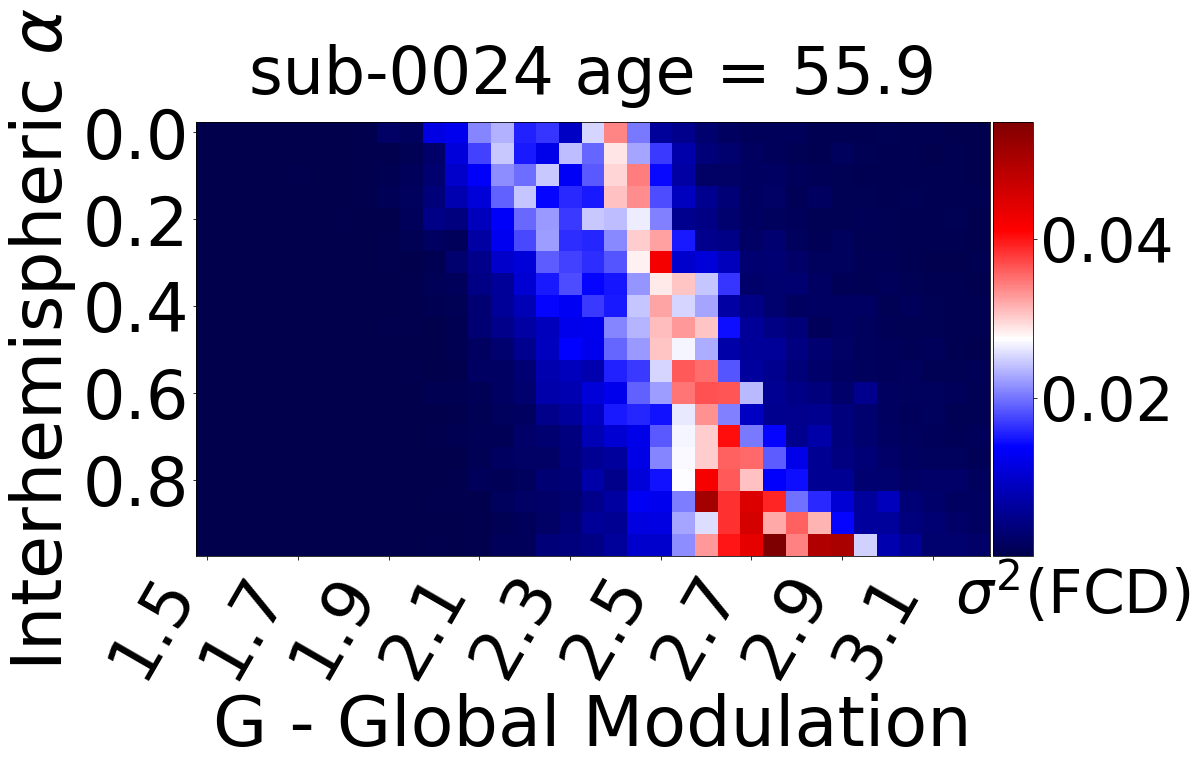

In [15]:
path_root  = os.path.dirname(os.getcwd())


f,ax = plt.subplots(figsize=(15,8))
# f,ax = plt.subplots()
image = ax.imshow(mymat,aspect='auto',cmap=plt.get_cmap('seismic'))

font_size = 60
plt.xticks(range(len(G_TAU)),G_VECT.round(7),rotation = 60, ha="right",fontsize=font_size+7);
plt.yticks(range(len(A_TAU)),A_TAU,fontsize=font_size+7);
ax.set_ylabel(r"Interhemispheric $\alpha$",fontsize=font_size+10)
# ax.set_xlabel(r"G with $\sigma^2_{noise}=0.035$",fontsize=font_size+10)
ax.set_xlabel("G - Global Modulation",fontsize=font_size+10)


mysubj     = P_LIST[sort_idx] 
myage_subj = str(myage_list[sort_idx])

mytit = separator.join([mysubj,' age = ',myage_subj])

plt.title(mytit,fontsize=font_size+5,y=1.05)


loc   = range(0,mymat.shape[1],4)
label = G_VECT.round(7)[loc]
label = label.round(2)

plt.xticks(loc, label);
# plt.yticks(loc, label);

loc2   = range(0,mymat.shape[0],4)
label2 = np.array(A_TAU)[loc2]
label2 = label2.round(2)

plt.yticks(loc2, label2);
# plt.yticks(loc, label);

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = f.colorbar(image, cax=cax)
cbar.ax.set_xlabel(r"$\sigma^2$(FCD)",fontsize=font_size,x=2.0)
cbar.ax.tick_params(labelsize=font_size)

## Output of the analysis on the virtual ageing brain

To speed up the process, we can upload the ($\alpha$-$G$) heatmap and the associated summary statistics saved in a intermediate results file, which are stored in `$MYPATH/aging_virtual_brain/data/interim`.

Intermediate results are also considered personal data, therefore 

### ***Re-read carefully the data alert block***

In [16]:
str_save_feature = separator.join(['interim/julich_100_VAB_ALPHA.npz'])

out_feature      = os.path.join(jul.data_root,str_save_feature)

summary_data     = np.load(out_feature)


P_LIST                = summary_data["P_LIST"]
myage_list            = summary_data["myage_list"]
mysubj_list           = summary_data["mysubj_list"]

FCD_SUBJ_VAR_TENSOR   = summary_data["FCD_SUBJ_VAR_TENSOR"]

G_SUBJ_VAR                = summary_data["G_SUBJ_VAR"]
NOISE_SUBJ_VAR            = summary_data["NOISE_SUBJ_VAR"]

FCD_VAR_MAX_VAR           = summary_data["FCD_VAR_MAX_VAR"]
FCD_MEAN_MAX_VAR          = summary_data["FCD_MEAN_MAX_VAR"]
FCD_VAR_DIFF_MAX_VAR      = summary_data["FCD_VAR_DIFF_MAX_VAR"]
FCD_STACK_INTER_MAX_VAR   = summary_data["FCD_STACK_INTER_MAX_VAR"]

HOMO_FC_MAX_VAR               = summary_data["HOMO_FC_MAX_VAR"]

#We can also check the trend by the level of noise

FCD_MEAN_GIVEN_FCD            = summary_data["FCD_MEAN_GIVEN_FCD"]

FCD_VAR_GIVEN_FCD             = summary_data["FCD_VAR_GIVEN_FCD"]

FCD_VAR_DIFF_GIVEN_FCD        = summary_data["FCD_VAR_DIFF_GIVEN_FCD"]

HOMO_FC_GIVEN_FCD             = summary_data["HOMO_FC_GIVEN_FCD"]

FCD_STACK_STD_INTER_GIVEN_FCD = summary_data["FCD_STACK_STD_INTER_GIVEN_FCD"]

ALPHA_MAT                     = summary_data["ALPHA_MAT"]
SUBJ_MAT                      = summary_data["SUBJ_MAT"]
         


In [17]:
SORT_AGE_LIST   = np.argsort(np.array(myage_list))
mypat_sort      = np.array(P_LIST)[SORT_AGE_LIST]
myage_sort      = np.array(myage_list)[SORT_AGE_LIST]

In [18]:
SORT_AGE_LIST

array([11,  9, 46, 16, 20,  2, 21,  0,  6, 37,  4, 38, 27, 36, 33, 18, 12,
       44, 24,  5, 49,  3, 23, 39, 17, 40, 26, 10, 19, 31, 32, 15, 42, 28,
       29, 45,  7, 34, 25, 30, 41,  1, 48, 35, 14, 22, 43,  8, 13, 47])

In [19]:
sort_idx = SORT_AGE_LIST[7]
NCHOS    = 1
mymat    = FCD_SUBJ_VAR_TENSOR[:,NCHOS,:,sort_idx].T.copy()

In [20]:
row_vect = np.where(np.isnan(mymat))[0]
col_vect = np.where(np.isnan(mymat))[1]

for row_idx,col_idx in zip(row_vect,col_vect):
    mymat[row_idx,col_idx] = (mymat[row_idx,col_idx-1] + mymat[row_idx,col_idx+1])/2

The code blocks below show once again how to obtain the $G-\alpha$ heatmap for three target subjects with the variables that colllect all the maps.

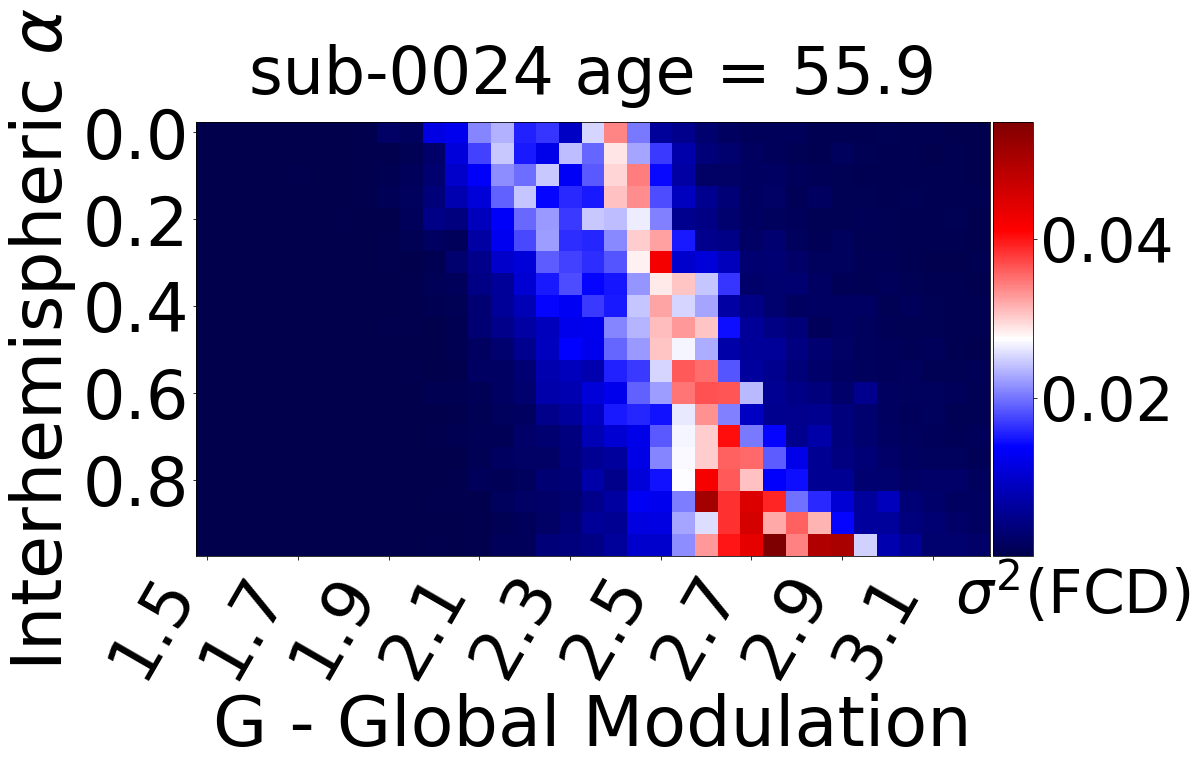

In [21]:
path_root  = os.path.dirname(os.getcwd())

f,ax = plt.subplots(figsize=(15,8))

image = ax.imshow(mymat,aspect='auto',cmap=plt.get_cmap('seismic'))

font_size = 60
plt.xticks(range(len(G_TAU)),G_VECT.round(7),rotation = 60, ha="right",fontsize=font_size+7);
plt.yticks(range(len(A_TAU)),A_TAU,fontsize=font_size+7);
ax.set_ylabel(r"Interhemispheric $\alpha$",fontsize=font_size+10)
ax.set_xlabel("G - Global Modulation",fontsize=font_size+10)

mysubj     = P_LIST[sort_idx] 
myage_subj = str(myage_list[sort_idx])

mytit = separator.join([mysubj,' age = ',myage_subj])

plt.title(mytit,fontsize=font_size+5,y=1.05)


loc   = range(0,mymat.shape[1],4)
label = G_VECT.round(7)[loc]
label = label.round(2)

plt.xticks(loc, label);
# plt.yticks(loc, label);

loc2   = range(0,mymat.shape[0],4)
label2 = np.array(A_TAU)[loc2]
label2 = label2.round(2)

plt.yticks(loc2, label2);
# plt.yticks(loc, label);

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = f.colorbar(image, cax=cax)
cbar.ax.set_xlabel(r"$\sigma^2$(FCD)",fontsize=font_size,x=2.0)
cbar.ax.tick_params(labelsize=font_size)



In the notebook `$MYPATH/aging_virtual_brain/notebooks/vab_github_summary_data.ipynb`, we investigated the trend of two summary statistics to check whether the SC deterioration is able to impact the functional communication and the dynamic interplay between the two hemispheres. As quick recap:

1. The homotopic functional connectivity is the average homologous connectivity strength (e.g right and left frontal region) and is defined as:

$$
<Homotopic_{FC}>=\frac{1}{N/2}\sum_{i,j=i+N/2}FC(i,j).
$$

2. The FCD dynamics difference is interplay between the full FCD variability and interhemispheric FCD variability and is computed as:

$$ 
\sigma^2_{diff} = ||Upper(FCD)_{interhemispheric-brain}||^2 - ||Upper(FCD)_{full-brain}||^2.
$$

The code blocks below show the trend of the virtually-aged features age-trend in function of $\alpha$ for the entire ensemble of 50 youngest subjects. For each feature, we report the median(IQR) Pearson correlation, which is computed for each individual. 

-0.8702981458351756
0.1485421441149214
-0.7764138553031804
-0.9249559994181018


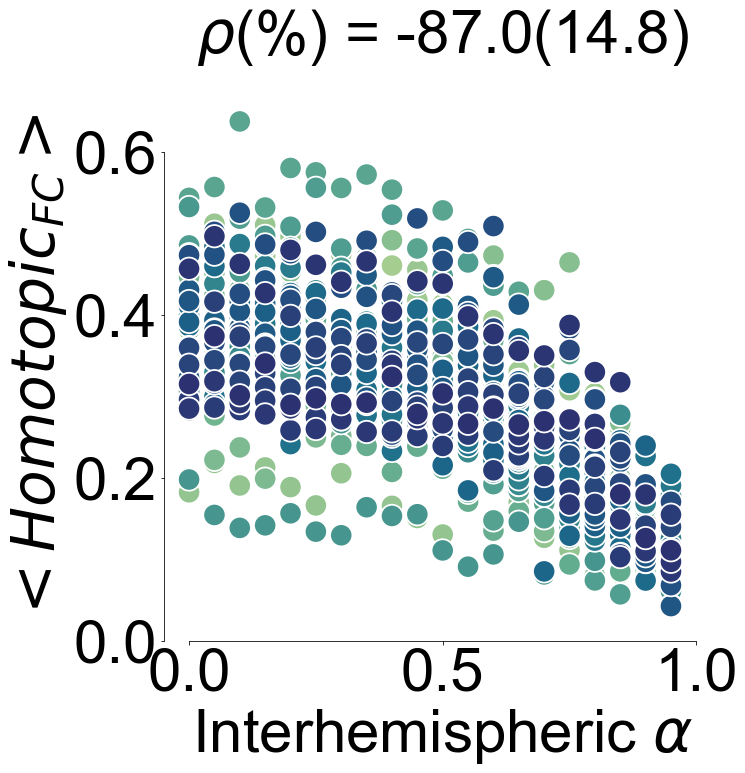

In [22]:
mymat        = HOMO_FC_MAX_VAR
mydata_plot  = mymat.ravel()
myalpha_plot = ALPHA_MAT.ravel()
mysubj_plot  = SUBJ_MAT.ravel()
myalpha       = np.array(A_TAU)

font_size = 60

f,ax          = plt.subplots(figsize=(10,10))

import seaborn as sns; sns.set_theme(color_codes=True)
sns.set_style("ticks")

path_root   = os.path.dirname(os.getcwd()) 
# palette = sns.color_palette("light:b")
palette  = sns.color_palette("Set2", 12)
sns.set_style({"xtick.major.size":30, "ytick.major.size":30})

separator = ''
str_yaxis = separator.join(['Average Structural Interhemispheric strength'])

sns.color_palette("hls", 8)

separator = ''
str_yaxis = separator.join([r'$<Homotopic_{FC}>$'])

corr_list_g = []

for PAT_IDX in range(HOMO_FC_MAX_VAR.shape[1]):
    
    mymat         = HOMO_FC_MAX_VAR[:,PAT_IDX]
#     data_reg = pd.DataFrame(
#         {'age':myalpha,
#         'feat_cc':mymat})
#     sns.regplot(x="age", y="feat_cc", data=data_reg,ax = ax,line_kws={"color":"k","alpha":.4},order=2,label='Quadratic fit')
    _, _, rvalue1,p_value, _  = stats.linregress(A_TAU,mymat)
#     cc_hat_1  = slope1*myalpha_inter + intercept1
    corr_list_g.append(rvalue1)
    


data_reg = pd.DataFrame(
        {'alpha':myalpha_plot,
        'feat_cc':mydata_plot,
        'subj':mysubj_plot})
    
    
sns.scatterplot(x="alpha", y="feat_cc", hue="subj",data=data_reg,ax = ax,s=500,legend=False,palette='crest')
    


plt.xlim([-0.05,1.05])
# plt.xticks(rotation = 55, ha="right",fontsize=font_size)
plt.xticks(fontsize=font_size)
# plt.ylim([0.0,0.25])
# sns.despine(trim=True);

ax.set_xlabel(r'Interhemispheric $\alpha$',fontsize=font_size)
ax.set_ylabel(str_yaxis,fontsize=font_size);

ax.tick_params(axis='x', labelsize=font_size)
ax.tick_params(axis='y', labelsize=font_size)

# ax.set_xticks([0.0, 0.2, 0.4 ,0.6,0.8,1.0])
ax.set_xticks([0.0, 0.5,1.0])
ax.set_yticks([0.0,0.2,0.4,0.6])


sns.despine(trim=True)


from matplotlib.ticker import FormatStrFormatter

ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

ax.set_title(r'$\rho$(%) = -87.0(14.8)',fontsize=font_size,y=1.07);


print(np.median(corr_list_g))
print(np.quantile(corr_list_g,.75)-np.quantile(corr_list_g,.25))
print(np.quantile(corr_list_g,.75))
print(np.quantile(corr_list_g,.25))



-0.8189257437760322
0.0
-0.8189257437760322
-0.8189257437760322


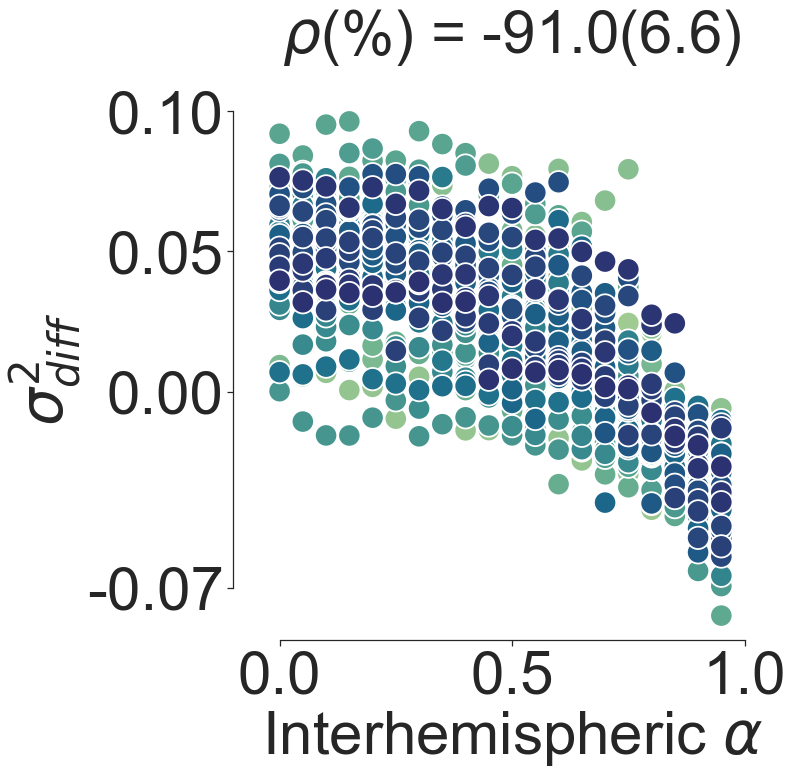

In [23]:
mymat        = FCD_VAR_DIFF_MAX_VAR
mydata_plot  = mymat.ravel()
myalpha_plot = ALPHA_MAT.ravel()
mysubj_plot  = SUBJ_MAT.ravel()
myalpha       = np.array(A_TAU)


font_size = 60
# plt.plot(mymat.T,'bd');


import seaborn as sns; sns.set_theme(color_codes=True)
sns.set_style("ticks")


# f,ax = plt.subplots(figsize=(10,10))
path_root   = os.path.dirname(os.getcwd()) 
# palette = sns.color_palette("light:b")
palette  = sns.color_palette("Set2", 12)
sns.set_style({"xtick.major.size":30, "ytick.major.size":30})

separator = ''
str_yaxis = separator.join(['Average Structural Interhemispheric strength'])

sns.color_palette("hls", 8)
f,ax = plt.subplots(figsize=(10,10))


separator = ''
# str_yaxis = separator.join(['VAR(I.FCD) - VAR(F.FCD)'])
str_yaxis = separator.join([r'$\sigma^2_{diff}$'])
# str_yaxis = ''

corr_list_g = []

for PAT_IDX in range(FCD_VAR_DIFF_MAX_VAR.shape[1]):

    mymat         = FCD_VAR_DIFF_MAX_VAR[:,PAT_IDX]
#     data_reg = pd.DataFrame(
#         {'age':myalpha,
#         'feat_cc':mymat})
#     sns.regplot(x="age", y="feat_cc", data=data_reg,ax = ax,line_kws={"color":"k","alpha":.4},order=2,label='Quadratic fit')
#     _, _, rvalue1,p_value, _  = stats.linregress(A_TAU,mymat)
    #     cc_hat_1  = slope1*myalpha_inter + intercept1
    corr_list_g.append(rvalue1)
    


data_reg = pd.DataFrame(
        {'alpha':myalpha_plot,
        'feat_cc':mydata_plot,
        'subj':mysubj_plot})
    
    
sns.scatterplot(x="alpha", y="feat_cc", hue="subj",data=data_reg,ax = ax,s=500,legend=False,palette='crest')
plt.xlim([-0.1,1.1])


ax.set_xlabel(r'Interhemispheric $\alpha$',fontsize=font_size)
ax.set_ylabel(str_yaxis,fontsize=font_size);

ax.tick_params(axis='x', labelsize=font_size)
ax.tick_params(axis='y', labelsize=font_size)

ax.set_xticks([0.0,0.5,1.0])
ax.set_yticks([-0.07,0.0,0.05,0.10])

sns.despine(trim=True)


from matplotlib.ticker import FormatStrFormatter

ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.set_title(r'$\rho$(%) = -91.0(6.6)',fontsize=font_size,y=1.07);

print(np.median(corr_list_g))
print(np.quantile(corr_list_g,.75)-np.quantile(corr_list_g,.25))
print(np.quantile(corr_list_g,.75))
print(np.quantile(corr_list_g,.25))


Similarly, we can track the selected $G$ and noise variance $\sigma^2$, associated to the red stripe of maximum $\sigma^(FCD)$ in the fludity landscape. Similarly to the summary statistics, we report the median(IQR) Pearson correlation, which is computed for each individual. 

0.8997363975133328
0.09820043031051573
0.9554908868864691
0.8572904565759534


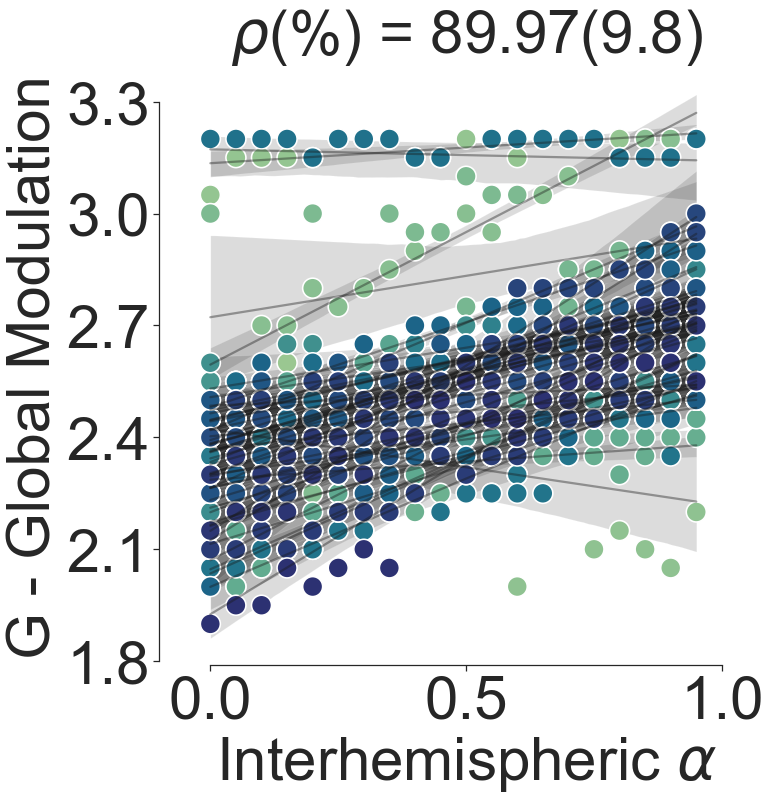

In [24]:
mymat        = G_SUBJ_VAR
mydata_plot  = mymat.ravel()
myalpha_plot = ALPHA_MAT.ravel()
mysubj_plot  = SUBJ_MAT.ravel()
myalpha       = np.array(A_TAU)

font_size = 60
import seaborn as sns; sns.set_theme(color_codes=True)
sns.set_style("ticks")


f,ax = plt.subplots(figsize=(11,11))
path_root   = os.path.dirname(os.getcwd()) 
# palette = sns.color_palette("light:b")
palette  = sns.color_palette("Set2", 12)
sns.set_style({"xtick.major.size":30, "ytick.major.size":30})

separator = ''
str_yaxis = separator.join(['Average Structural Interhemispheric strength'])

sns.color_palette("hls", 8)

separator = ''
str_yaxis = separator.join(['G - Global Modulation'])
# str_yaxis = ''

corr_list_g = []

for PAT_IDX in range(G_SUBJ_VAR.shape[1]):
    
    mymat         = G_SUBJ_VAR[:,PAT_IDX]
    data_reg = pd.DataFrame(
        {'age':myalpha,
        'feat_cc':mymat})
    sns.regplot(x="age", y="feat_cc", data=data_reg,ax = ax,line_kws={"color":"k","alpha":.4},order=1)
    _, _, rvalue1,p_value, _  = stats.linregress(A_TAU,mymat)
#     cc_hat_1  = slope1*myalpha_inter + intercept1
    corr_list_g.append(rvalue1)


data_reg = pd.DataFrame(
        {'alpha':myalpha_plot,
        'feat_cc':mydata_plot,
        'subj':mysubj_plot})
    
    
sns.scatterplot(x="alpha", y="feat_cc", hue="subj",data=data_reg,ax = ax,s=400,legend=False,palette='crest')


plt.xlim([-0.1,1.1])


ax.set_xlabel(r'Interhemispheric $\alpha$',fontsize=font_size)
ax.set_ylabel(str_yaxis,fontsize=font_size);

ax.set_xticks([0.0,0.5,1.0])
ax.set_yticks([1.8,2.1,2.4,2.7,3.0,3.3])
# ax.set_yticks([])

ax.tick_params(axis='x', labelsize=font_size)
ax.tick_params(axis='y', labelsize=font_size)

sns.despine(trim=True)


from matplotlib.ticker import FormatStrFormatter

ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

ax.set_title(r'$\rho$(%) = 89.97(9.8)',fontsize=font_size);


print(np.median(corr_list_g))
print(np.quantile(corr_list_g,.75)-np.quantile(corr_list_g,.25))
print(np.quantile(corr_list_g,.75))
print(np.quantile(corr_list_g,.25))

0.05874296615153245
0.43746034678564616
0.25441771341896413
-0.18304263336668203


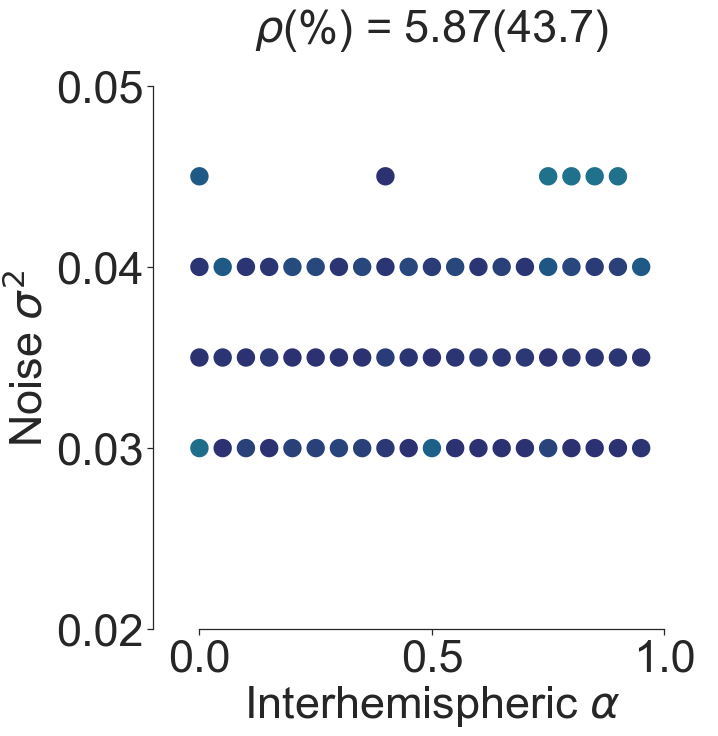

In [25]:
mymat        = NOISE_SUBJ_VAR
mydata_plot  = mymat.ravel()
myalpha_plot = ALPHA_MAT.ravel()
mysubj_plot  = SUBJ_MAT.ravel()
myalpha       = np.array(A_TAU)

font_size = 45
import seaborn as sns; sns.set_theme(color_codes=True)
sns.set_style("ticks")

path_root   = os.path.dirname(os.getcwd()) 
palette  = sns.color_palette("Set2", 12)
sns.set_style({"xtick.major.size":30, "ytick.major.size":30})

separator = ''
str_yaxis = separator.join(['Average Structural Interhemispheric strength'])

sns.color_palette("hls", 8)

f,ax = plt.subplots(figsize=(10,10))


separator = ''
str_yaxis = separator.join([r'Noise $\sigma^2$'])

corr_list_g = []

for PAT_IDX in range(NOISE_SUBJ_VAR.shape[1]):

    mymat         = NOISE_SUBJ_VAR[:,PAT_IDX]
    #     data_reg = pd.DataFrame(
    #         {'age':myalpha,
    #         'feat_cc':mymat})
    #     sns.regplot(x="age", y="feat_cc", data=data_reg,ax = ax,line_kws={"color":"k","alpha":.4},order=1)
    _, _, rvalue1,p_value, _  = stats.linregress(A_TAU,mymat)
    #     cc_hat_1  = slope1*myalpha_inter + intercept1
    corr_list_g.append(rvalue1)
    


data_reg = pd.DataFrame(
        {'alpha':myalpha_plot,
        'feat_cc':mydata_plot,
        'subj':mysubj_plot})
    
    
sns.scatterplot(x="alpha", y="feat_cc", hue="subj",data=data_reg,ax = ax,s=400,legend=False,palette='crest')

plt.xlim([-0.1,1.1])

ax.set_xlabel(r'Interhemispheric $\alpha$',fontsize=font_size)
ax.set_ylabel(str_yaxis,fontsize=font_size);

ax.tick_params(axis='x', labelsize=font_size)
ax.tick_params(axis='y', labelsize=font_size)

ax.set_yticks([0.02,0.03,0.04,0.05])

sns.despine(trim=True)


from matplotlib.ticker import FormatStrFormatter

ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.set_title(r'$\rho$(%) = 5.87(43.7)',fontsize=font_size,y=1.07);

print(np.median(corr_list_g))
print(np.quantile(corr_list_g,.75)-np.quantile(corr_list_g,.25))
print(np.quantile(corr_list_g,.75))
print(np.quantile(corr_list_g,.25))
